In [169]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [8]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [9]:
!python -m wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv


Saved under data.csv


In [16]:
data = pd.read_csv('data.csv')

In [17]:
features = [
    'Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders',
    'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP'
]

In [18]:

data = data[features]

In [19]:
data = data.rename(columns={'MSRP': 'price'})
data.columns = data.columns.str.replace(' ', '_').str.lower()

In [21]:
data.isna().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
price                 0
dtype: int64

In [24]:
data['engine_hp'] = data['engine_hp'].fillna(0)
data['engine_cylinders'] = data['engine_cylinders'].fillna(0)

In [25]:
data_class = data.copy()
mean = data_class['price'].mean()

data_class['above_average'] = np.where(data_class['price']>=mean,1,0)

In [26]:
data_class

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500,0
...,...,...,...,...,...,...,...,...,...,...,...
11909,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,46120,1
11910,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,56670,1
11911,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,50620,1
11912,Acura,ZDX,2013,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,50920,1


In [28]:
SEED = 1
df_full_train, df_test = train_test_split(data_class, test_size=0.2, random_state=SEED)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=SEED)

assert len(data_class) == (len(df_train) + len(df_val) + len(df_test))

In [30]:
len(df_train), len(df_val), len(df_test)

(7148, 2383, 2383)

In [31]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

In [63]:
categorical = list(data_class.dtypes[data_class.dtypes == 'object'].index)
numerical = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg' ]

In [64]:
roc_score = []
for n in numerical:
    score = roc_auc_score(df_train['above_average'], df_train[n] )
    if score < 0.5:
        score = roc_auc_score(df_train['above_average'], -df_train[n] )
    roc_score.append(score)
    print('%s %.3f'%(n, score))

engine_hp 0.917
engine_cylinders 0.766
highway_mpg 0.633
city_mpg 0.673


In [66]:
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    x_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(x_train, y_train)
    
    return dv, model

In [74]:
dv, model = train(df_train,y_train)

In [75]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    x = dv.transform(dicts)
    y_pred = model.predict_proba(x)[:,1]
    
    return y_pred

In [82]:
y_pred = predict(df_val, dv, model)
roc_auc_score(y_val, y_pred).round(3)

0.982

In [87]:
np.arange(0, 1.01, 0.01)


array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [95]:
def tpr_fpr_Dataframe(y_val, y_pred):
    thresholds = np.arange(0, 1.01, 0.01)
    scores = []

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t )
        predict_negative = (y_pred < t  )

        tp = (actual_positive & predict_positive).sum()
        tn = (actual_negative & predict_negative).sum()

        fp = (actual_negative & predict_positive).sum()
        fn = (actual_positive & predict_negative).sum()
        
        scores.append((t, tp, fp, fn, tn))

        columns = ['thresholds', 'tp', 'fp', 'fn', 'tn']
        df_scores = pd.DataFrame(scores, columns=columns)

        df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
        df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
        
    return df_scores

In [97]:
df_scores = tpr_fpr_Dataframe(y_val, y_pred)
df_scores[:10]

,thresholds,tp,fp,fn,tn,recall,precision
0,0.00,654,1729,0,0,1.000000,0.274444
1,0.01,652,811,2,918,0.996942,0.445660
2,0.02,652,664,2,1065,0.996942,0.495441
3,0.03,651,591,3,1138,0.995413,0.524155
4,0.04,651,513,3,1216,0.995413,0.559278
5,0.05,650,464,4,1265,0.993884,0.583483
6,0.06,650,439,4,1290,0.993884,0.596878
7,0.07,647,401,7,1328,0.989297,0.617366
8,0.08,647,373,7,1356,0.989297,0.634314
9,0.09,647,357,7,1372,0.989297,0.644422


The threshold at which precision and recall curves intersect is: 0.48


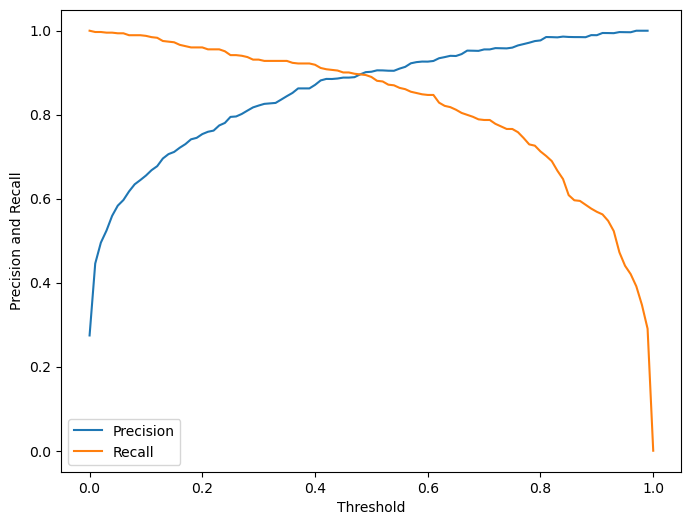

In [109]:
plt.figure(figsize=(8, 6))
plt.plot(df_scores.thresholds, df_scores['precision'], label='Precision')
plt.plot(df_scores.thresholds, df_scores['recall'], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision and Recall')
plt.legend()

intersection_threshold = df_scores.thresholds[np.argmax(np.abs(np.array(df_scores['precision']) == np.array(df_scores['recall'])))]
print(f"The threshold at which precision and recall curves intersect is: {intersection_threshold}")


In [142]:
def tpr_fpr_Dataframe(y_val, y_pred):
    thresholds = np.arange(0, 1.01, 0.01)
    scores = []

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t )
        predict_negative = (y_pred < t  )

        tp = (actual_positive & predict_positive).sum()
        tn = (actual_negative & predict_negative).sum()

        fp = (actual_negative & predict_positive).sum()
        fn = (actual_positive & predict_negative).sum()
        
        scores.append((t, tp, fp, fn, tn))

        columns = ['thresholds', 'tp', 'fp', 'fn', 'tn']
        df_scores = pd.DataFrame(scores, columns=columns)

        df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
        df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
        df_scores['F1'] = 2*((df_scores.precision*df_scores.recall)+(df_scores.precision*df_scores.recall))
        
    return df_scores


In [168]:
df_scores = tpr_fpr_Dataframe(y_val, y_pred)
df_scores.F1.idxmax()

49

In [166]:
df_scores.loc[49]

thresholds       0.490000
tp             585.000000
fp              64.000000
fn              69.000000
tn            1665.000000
recall           0.894495
precision        0.901387
F1               3.225145
Name: 49, dtype: float64

In [176]:
n_splits = 5
scores = []
    
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
for train_idx, val_idx in tqdm(kfold.split(df_full_train), total=n_splits):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val   = df_val.above_average.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    print(' %.3f +- %.3f '% ( np.mean(scores), np.std(scores)))

  0%|          | 0/5 [00:00<?, ?it/s]

 0.982 +- 0.000 
 0.983 +- 0.001 
 0.983 +- 0.001 
 0.983 +- 0.001 
 0.984 +- 0.002 


In [177]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    x_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(x_train, y_train)
    
    return dv, model

In [178]:
n_splits = 5
for C in tqdm([0.01, 0.1, 0.5, 10]):
    scores = []
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val   = df_val.above_average.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print('C=%s %.3f +- %.3f '% (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.938 +- 0.002 
C=0.1 0.973 +- 0.003 
C=0.5 0.982 +- 0.002 
C=10 0.987 +- 0.002 
